# Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score

data = pd.read_csv("./data/fashion-mnist_train.csv")
images = data.iloc[:, 1:]
labels = data.iloc[:, 0]
label_map = {0: 'T-shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle'}

def label_str(label):
    return label_map[label]


# Scaling and normalising the data
scaler = StandardScaler()
images_scaled = pd.DataFrame(scaler.fit_transform(images))
images_norm = normalize(images_scaled)

# Dimensionality reduction
pca = PCA(n_components = 784)
# pca = PCA()
data_pca = pca.fit_transform(images_norm)
data_pca = pd.DataFrame(data_pca, columns=["PC{}".format(n) for n in range(1, 785)])
# data_pca["type"] = labels.map(label_map)

cum_sum = np.cumsum(pca.explained_variance_ratio_)
pca_dims = np.argmax(cum_sum >= 0.95) + 1

# Clustering
Page 6 in the project report

Hierarchical clustering

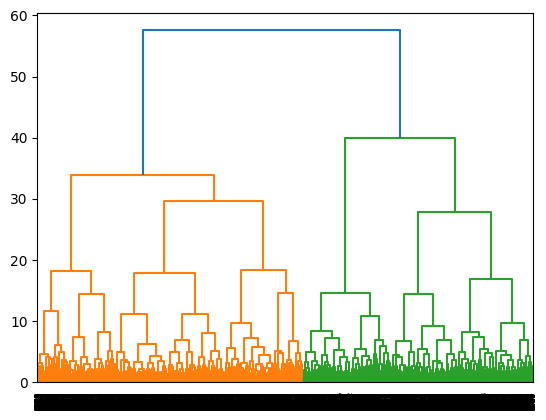

euclidean-ward: 0.43737384641538707
manhattan-average: -2.42359479432936e-06
cosine-average: 0.2851482983859039


In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(data_pca.iloc[:10000, 0:pca_dims], 'ward')
dendrogram(linkage_matrix)
plt.show()

metrics = ["euclidean", "manhattan", "cosine"]
for met in metrics:
    hierarchical_cluster = AgglomerativeClustering(n_clusters=10, metric=met, linkage="ward" if met == "euclidean" else "average")
    cluster_labels = hierarchical_cluster.fit_predict(data_pca.iloc[:10000, 0:pca_dims])
    print(str(met) + "-" + ("ward" if met == "euclidean" else "average") + ": " + str(adjusted_rand_score(labels.iloc[:10000], cluster_labels)))

Partition clustering

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(images_norm[:10000])
print(adjusted_rand_score(labels.iloc[:10000], kmeans.labels_))

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(data_pca.iloc[:10000, 0:pca_dims])
print(adjusted_rand_score(labels.iloc[:10000], kmeans.labels_))

0.3615279682824771
0.3822919737843047


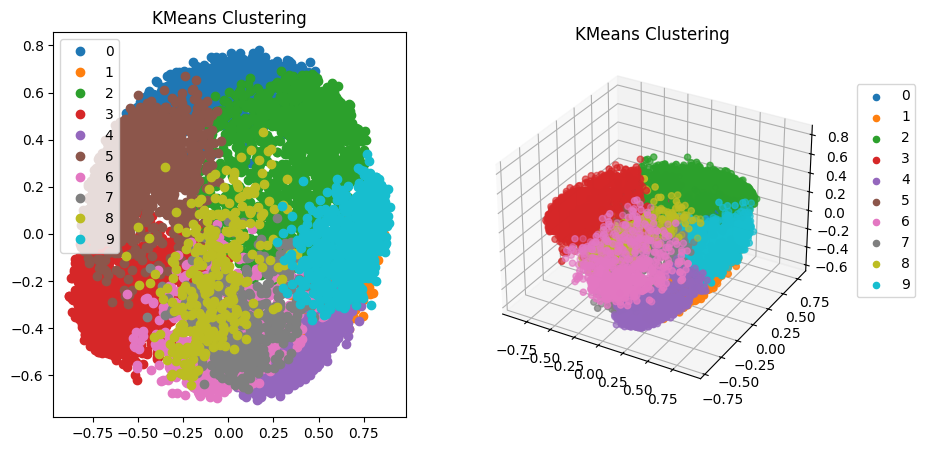

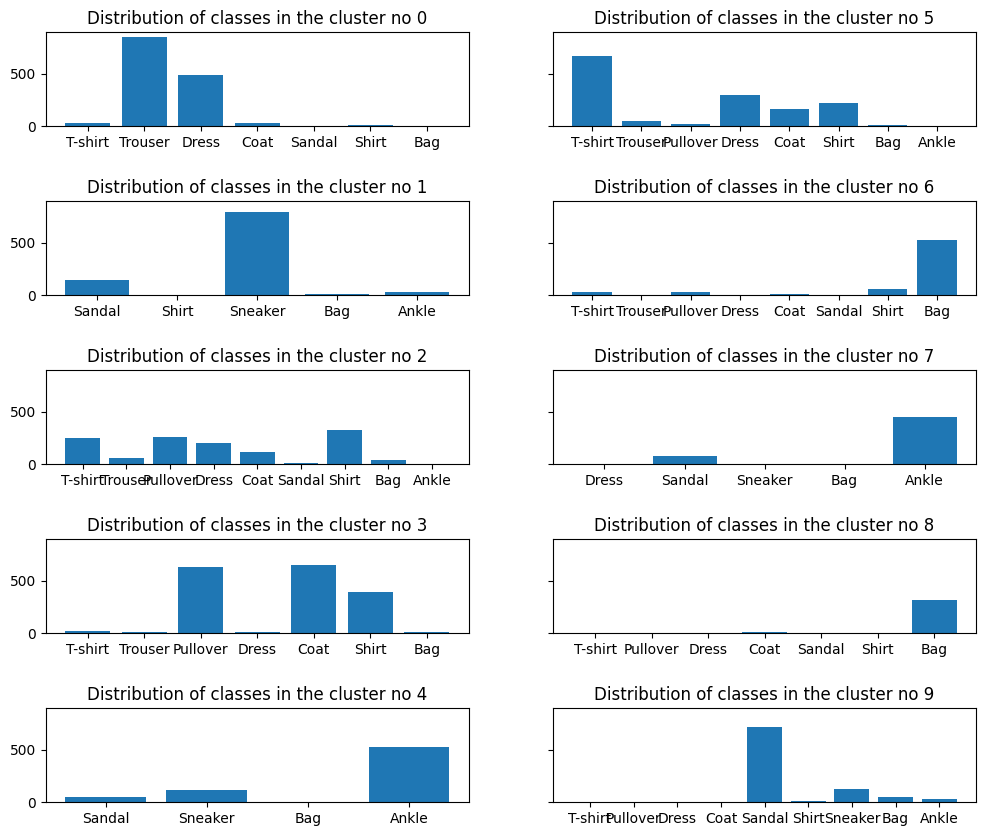

In [25]:
km = data_pca.iloc[:10000, 0:pca_dims]
km["type"] = kmeans.labels_
km["real_type"] = labels.iloc[:10000]
# print(data_pca.head(5))

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))

groups = km.groupby("type")
for name, group in groups:
    axs[0].plot(group["PC1"], group["PC2"], marker="o", linestyle="", label=name)
axs[0].legend()
t=axs[0].set_title("KMeans Clustering")

axs[1].remove()
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

d={}
fig2, axs2 = plt.subplots(5, 2, sharey=True, figsize=(12,10))
groups = km.groupby("type")
for name, group in groups:
    ax2.scatter(group["PC1"], group["PC2"], group["PC3"], marker="o", label=name)
    
    g = group.groupby("real_type")
    d[name]={}
    for real_name, group2 in g:
        d[name][label_str(real_name)] = len(group2)
    sizes=d[name].values()
    barLabels=d[name].keys()
    axs2[name%5][0 if name<5 else 1].bar(barLabels, sizes, label='Cluster '+ str(name))
    axs2[name%5][0 if name<5 else 1].set_title("Distribution of classes in the cluster no "+str(name))
    axs2[name%5][0 if name<5 else 1].autoscale()


ax2.legend(bbox_to_anchor=(1.08, 0.9), loc='upper left', borderaxespad=0)
t=ax2.set_title("KMeans Clustering")
plt.subplots_adjust(hspace=0.8)

# Classification
Page 9 in the project report

KNeighborsClassifier

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

scaler = StandardScaler()
kf = KFold(n_splits=5)

fold_accuracies = []
for i, (train_index, test_index) in enumerate(kf.split(images)):
    # neigh = KNeighborsClassifier(leaf_size=20, metric='minkowski', n_neighbors=10, p=2, weights='uniform', n_jobs=-1)
    neigh = KNeighborsClassifier(leaf_size=20, metric='manhattan', n_neighbors=10, weights='uniform', n_jobs=-1)

    X_train_normalized = pd.DataFrame(scaler.fit_transform(images.iloc[train_index]))
    X_test_normalized = pd.DataFrame(scaler.transform(images.iloc[test_index]))

    neigh.fit(X_train_normalized, labels.iloc[train_index])
    accuracy = neigh.score(X_test_normalized, labels.iloc[test_index])
    print(accuracy)
    fold_accuracies.append(accuracy)


average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"Average Accuracy: {average_accuracy:.2f}")

0.8619166666666667
0.8578333333333333
0.8619166666666667
0.8535833333333334
0.8583333333333333
Average Accuracy: 0.86


In [41]:
d={}
for metric in ["euclidean","manhattan","cosine"]:
    for neighbors in range (1,10):

        accuracy = 0

        for i, (train_index, test_index) in enumerate(kf.split(data_pca.iloc[:10000,:pca_dims])):
            knn = KNeighborsClassifier(leaf_size=20, n_neighbors=neighbors, metric=metric, p=2, n_jobs=-1)
            knn.fit(images.iloc[train_index],labels.iloc[train_index])
            accuracy += knn.score(images.iloc[test_index],labels.iloc[test_index])

        accuracy /= 5

        if metric in d.keys():
            d[metric].append(accuracy)
        else:
            d[metric] = [accuracy]

knn_results = pd.DataFrame(data=d)
knn_results

,euclidean,manhattan,cosine
0,0.8104,0.8221,0.8188
1,0.8082,0.8117,0.8176
2,0.8184,0.8289,0.8207
3,0.8196,0.8316,0.8227
4,0.8189,0.8287,0.8185
5,0.8200,0.8278,0.8175
6,0.8146,0.8279,0.8118
7,0.8172,0.8296,0.8140
8,0.8143,0.8292,0.8103


Decision tree

0.7935


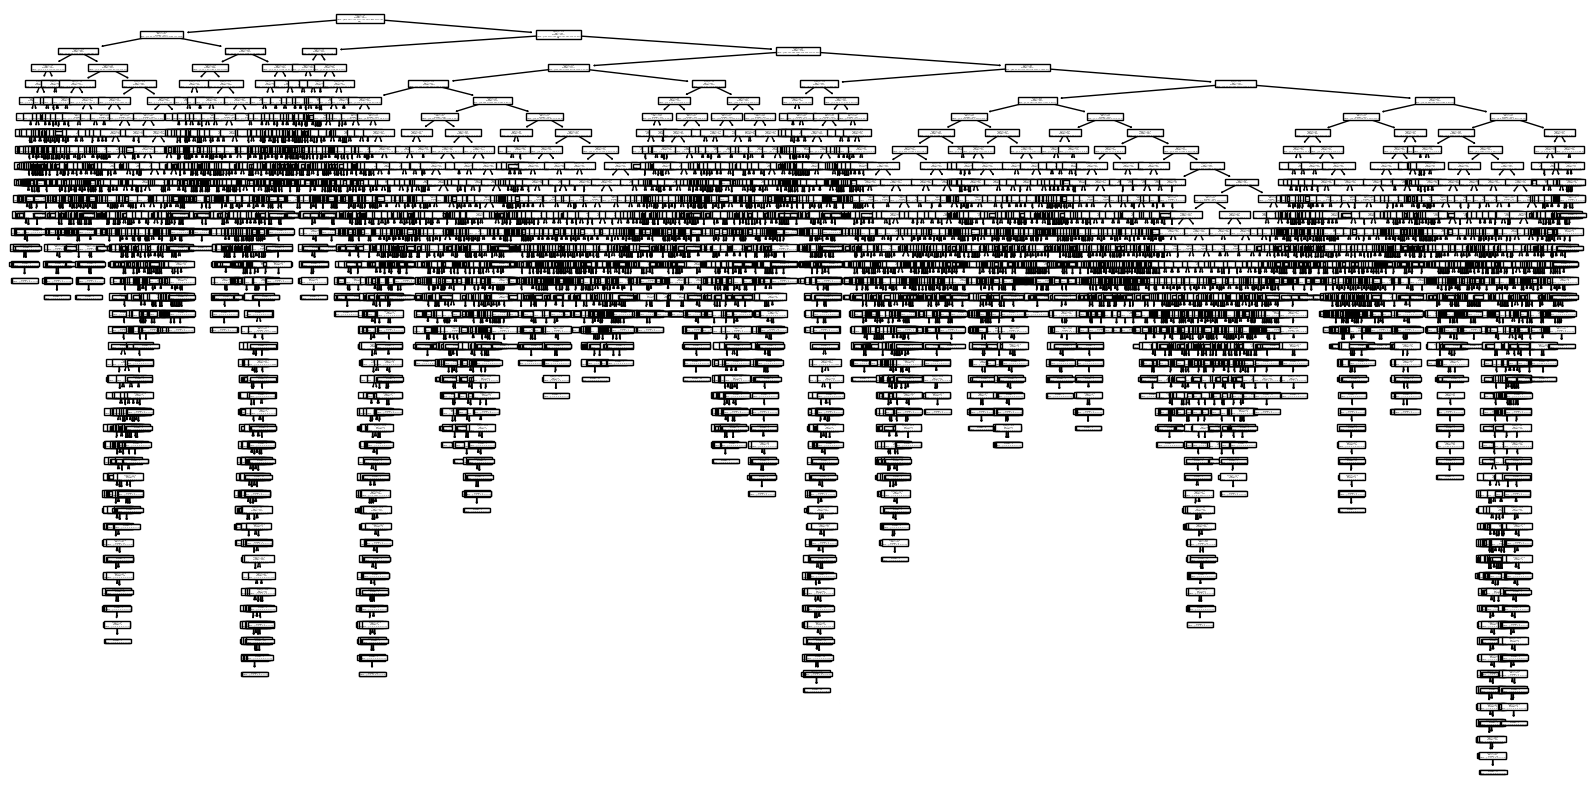

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.20, random_state=10)
clf = DecisionTreeClassifier(criterion='gini', random_state=10)
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))

fig, ax = plt.subplots(figsize=(20, 10))  #20/10
plot_tree(clf, ax=ax)
plt.show()